In [46]:
import os
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [61]:
# Function for reading the data (hard-coded for now)
def read_data(filename):
    
    _, ext = os.path.splitext(filename)
    
    if ext == '.csv':
        df = pd.read_csv(filename, index_col=0)
    elif ext == '.xls':
        df = pd.read_excel(filename, header=1)
    
    return df

## Read Data

First, we will read the dataset and the data dictionary for the dataset.

In [62]:
# Read 'credit-data.csv'
df = read_data('data/credit-data.csv')

In [63]:
df.shape

(41016, 12)

In [64]:
# data/data-dictionary.xls
data_dict = read_data('data/data-dictionary.xls')

In [65]:
data_dict.head(12)

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,zipcode,zipcode of the borrower,interget/string
5,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
6,MonthlyIncome,Monthly income,real
7,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
8,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
9,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer


## Exploratory Data Analysis

We will look at distributions of variables, correlations between them, and summarize data.

### The Distribution of the Outcome Variable

The Outcome Variable: __*SeriousDlgin2yrs*__

In [66]:
df['SeriousDlqin2yrs'].value_counts()

0    34396
1    6620 
Name: SeriousDlqin2yrs, dtype: int64

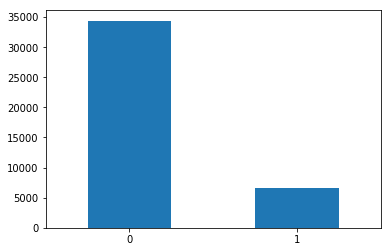

In [67]:
df['SeriousDlqin2yrs'].value_counts().plot('bar', rot=0)

There are an imbalance in the outcome variable. Specifically, there are far more people who experienced 90 days past due delinquency or worse.

### Missing Values

Now we should look at the number of missing values in each column.

In [68]:
def generate_nan_df(df):
    
    nan = df.isna().sum()
    nan_perc = round(100 * nan / len(df.index), 2)
    nan_df = pd.concat([nan, nan_perc], axis=1)
    nan_df = nan_df.rename(columns = {0: 'NaN', 1: 'Percent of NaN'})
    nan_df = nan_df.sort_values(by=['Percent of NaN'], ascending=False)
    
    return nan_df

In [69]:
# Check the missing data
nan_df = generate_nan_df(df)
nan_df.head(13)

,NaN,Percent of NaN
MonthlyIncome,7974,19.44
NumberOfDependents,1037,2.53
SeriousDlqin2yrs,0,0.00
RevolvingUtilizationOfUnsecuredLines,0,0.00
age,0,0.00
zipcode,0,0.00
NumberOfTime30-59DaysPastDueNotWorse,0,0.00
DebtRatio,0,0.00
NumberOfOpenCreditLinesAndLoans,0,0.00
NumberOfTimes90DaysLate,0,0.00


- We can see that there are a lot of missing data for __MonthlyIncome__ and __NumberOfDependents__.
- Therefore, we probably do not want to simply drop all missing data.

In [70]:
df.dtypes

SeriousDlqin2yrs                        int64  
RevolvingUtilizationOfUnsecuredLines    float64
age                                     int64  
zipcode                                 int64  
NumberOfTime30-59DaysPastDueNotWorse    int64  
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans         int64  
NumberOfTimes90DaysLate                 int64  
NumberRealEstateLoansOrLines            int64  
NumberOfTime60-89DaysPastDueNotWorse    int64  
NumberOfDependents                      float64
dtype: object

In [71]:
corr = df.corr()['NumberOfDependents'].sort_values()
corr.head(13)

age                                    -0.211002
DebtRatio                              -0.070558
NumberOfTime60-89DaysPastDueNotWorse   -0.016493
NumberOfTimes90DaysLate                -0.015737
NumberOfTime30-59DaysPastDueNotWorse   -0.007840
zipcode                                -0.001744
RevolvingUtilizationOfUnsecuredLines    0.005342
NumberOfOpenCreditLinesAndLoans         0.060218
MonthlyIncome                           0.060528
SeriousDlqin2yrs                        0.065708
NumberRealEstateLoansOrLines            0.114880
NumberOfDependents                      1.000000
Name: NumberOfDependents, dtype: float64

In [94]:
def generate_corr_heatmap(df):

    # compute correlation
    corr = df.corr()
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # create figure and plot
    f, ax = plt.subplots(figsize=(15, 5))
    
    # Generate a diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap=cmap, linewidths=.5)

    plt.show()

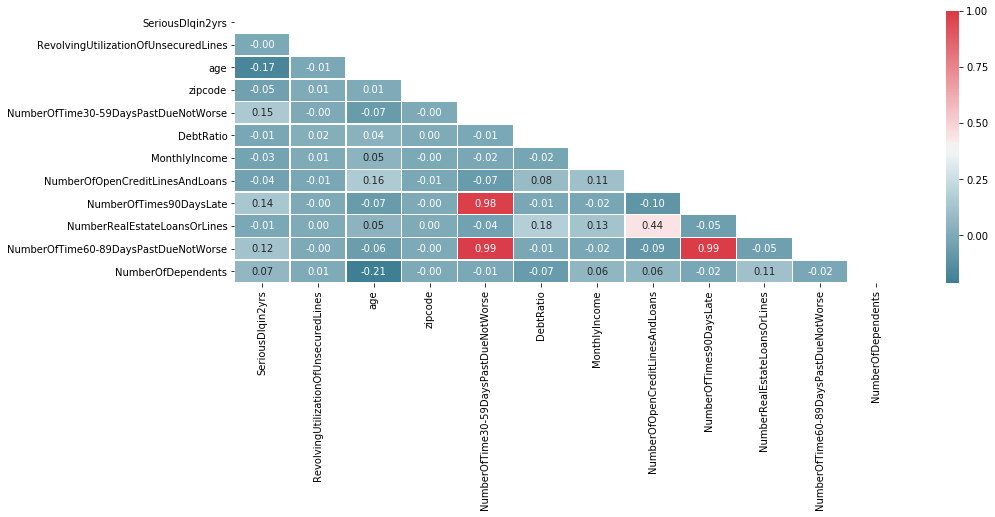

In [95]:
generate_corr_heatmap(df)

We will use the average value of __MonthlyIncome__ and the most common value of __NumberOfDependents__ to fill these missing data. 

In [ ]:
g = sns.FacetGrid(df, col='SeriousDlqin2yrs')
g.map(plt.hist, 'age', bins=20)

In [ ]:
g = sns.FacetGrid(df, col='SeriousDlqin2yrs')
g.map(plt.hist, 'NumberofDependents', bins=20)

In [ ]:
def fill_continuous_na(df, columns):
    
    for column in columns:
        estimate = round(df[column].mean())
        df[column] = df[column].fillna(estimate)
    
    return df

In [ ]:
def fill_categorical_na(df, columns):
    
    for column in columns:
        df[column] = df[column].fillna(99)
        estimate = df[column].value_counts().index[0]
        df[column] = df[column].replace([99], estimate)
    
    return df

In [ ]:
df = fill_continuous_na(df, ['MonthlyIncome'])
df = fill_categorical_na(df, ['NumberOfDependents'])

Now we verify that there is no missing data.

In [ ]:
df.isna().sum()

Now that the data seems complete, we should take a closer look at our variables. Specifically, let us have a look at the data dictionary.

In [ ]:
# data/data-dictionary.xls
data_dict = read_data('data/data-dictionary.xls')

In [ ]:
data_dict.head(14)

In [ ]:
df.SeriousDlqin2yrs.value_counts()

In [ ]:
g = sns.FacetGrid(df, col='SeriousDlqin2yrs')
g.map(plt.hist, 'age', bins=20)

In [ ]:
g = sns.FacetGrid(df, col='SeriousDlqin2yrs')
g.map(plt.hist, 'NumberOfDependents', bins=20)

In [ ]:
df.NumberOfDependents.unique()

In [ ]:
estimate